# Skin Cancer Identification
## Leveraging Deep Learning To Classify Common Skin Cancer Types

### by Nicholas Kondis

## Introduction

Skin cancer is one of the most common types of cancer worldwide, with millions of new cases diagnosed each year. Early detection and accurate diagnosis are crucial for effective treatment, as survival rates significantly increase when skin cancer is identified in its early stages. 

Some important facts about Skin Cancer

1. More people are diagnosed with skin cancers than all other types of cancers combined
2. 1 in 5 Americans will develop skin cancer by age 70
3. In the US, on average, more than 2 people die from skin cancer every hour
4. With early detection, the survival rate of skin cancer is over 99 percent
5. Effective identification of types of skin cancers allows efficient use of resources and therapies
6. The annual cost of treating skin cancers in the U.S. is estimated at $8.1 billion


Distinguishing between benign and malignant skin lesions can be challenging, even for experienced dermatologists. To address this challenge, I have explored several CNN models (including creation of models and adapting pre-trained models) designed to classify images into one of seven types of skin cancer. Leveraging a deep learning approach, the models has been trained on a large dataset (HAM10000) of labeled skin images to learn the subtle differences between various types of lesions. The CNN architecture was fine-tuned to optimize performance and enhance the model's accuracy. This project aims to provide a reliable tool that can assist healthcare professionals in the early detection of skin cancer, ultimately improving patient outcomes. The model's ability to analyze and classify skin images rapidly could also reduce the workload on medical professionals, allowing them to focus on more complex cases. By implementing this model in a web-based application, we aim to make skin cancer diagnosis more accessible and efficient. The development and deployment of this CNN highlight the potential of AI in revolutionizing the field of dermatology and cancer diagnosis.


In [21]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf

I will begin by first looking at the data set used for this project.  This is a csv file containing labels for the images in the HAM10000 dataset.  As stated above, this is a data set of the labels of seven skin cancer types: melanoma (MEL), melanocytic nevi (NV), basal cell carcinoma (BCC), Actinic keratoses (AKIEC), benign keratosis-like lesions (BKL), dermatofibroma (DF), and vascular lesions (VASC).



In [22]:
# read the csv file that contains the imape labels (classes)

sc_labels = pd.read_csv('GroundTruth.csv')
sc_labels.head()


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

To prevent any issues before creating the model, we will first do some exploratory data analysis.

Here, I am checking the data types for missing values before modeling.

In [23]:
# Check for missing values
sc_labels.isna().sum()

image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64

Since there are no missing values, I will now check to make sure no images are labeled with multiple types.

In [24]:
for column in sc_labels.columns[1:]:
    unique_values = sc_labels[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'MEL': [0. 1.]
Unique values in column 'NV': [1. 0.]
Unique values in column 'BCC': [0. 1.]
Unique values in column 'AKIEC': [0. 1.]
Unique values in column 'BKL': [0. 1.]
Unique values in column 'DF': [0. 1.]
Unique values in column 'VASC': [0. 1.]


In [25]:
# Check for rows with multiple 1.0 labels in the binary columns
rows_with_multiple_ones = []
for index, row in sc_labels.iterrows():
    if sum(row.iloc[1:]) > 1:  # Exclude the first column
        rows_with_multiple_ones.append(index)

if rows_with_multiple_ones:
    print("Rows with multiple '1.0' labels:")
    for index in rows_with_multiple_ones:
        print(sc_labels.iloc[index])
else:
    print("No rows with multiple '1.0' labels.")


No rows with multiple '1.0' labels.


The information above indicates that we have a clean dataset, no missing values and unique identifiers for each image.

One issue that will be addressed later is the variation in image sizes, as the images are not currently standardized. This will be managed during the data loading step for the convolutional neural network, where the images will be prepared accordingly.

It's important to note that the models used below will require different dimensional inputs due to the varying sizes of the images.

Additionally, I have implemented several pre-trained models, including ResNet50, EfficientNetB0, InceptionV3, VGG16, DenseNet, Xception, and NASNetMobile.

However, due to time constraints, these models have not yet been run.

In anticipation of the results, I have also created an ensemble classifier. This method averages the predictions of each model and classifies based on consensus, with the goal of improving overall classification accuracy. All models are included in the code, though adjustments may be made depending on the accuracy statistics of each model.


In [26]:
# Define the path to the dataset
data_dir = 'HAM10000'

# List all files in the directory
file_names = os.listdir(data_dir)

# Load the metadata
metadata_path = os.path.join(data_dir, 'GroundTruth.csv')
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
metadata.head()


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Display the columns of the metadata
print(metadata.columns)

# Display the first few rows of the metadata
print(metadata.head())


Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [28]:
# Create a list the binary columns representing different types of skin cancer for labeling
class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Create a function to map binary columns to a single label
def map_labels(row):
    for col in class_columns:
        if row[col] == 1.0:
            return col
    return 'unknown'

# Apply the function to create the 'labels' column
metadata['labels'] = metadata.apply(map_labels, axis=1)

# Display the first few rows to verify the new 'labels' column
print(metadata.head())



          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC labels
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0    MEL


labels
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64


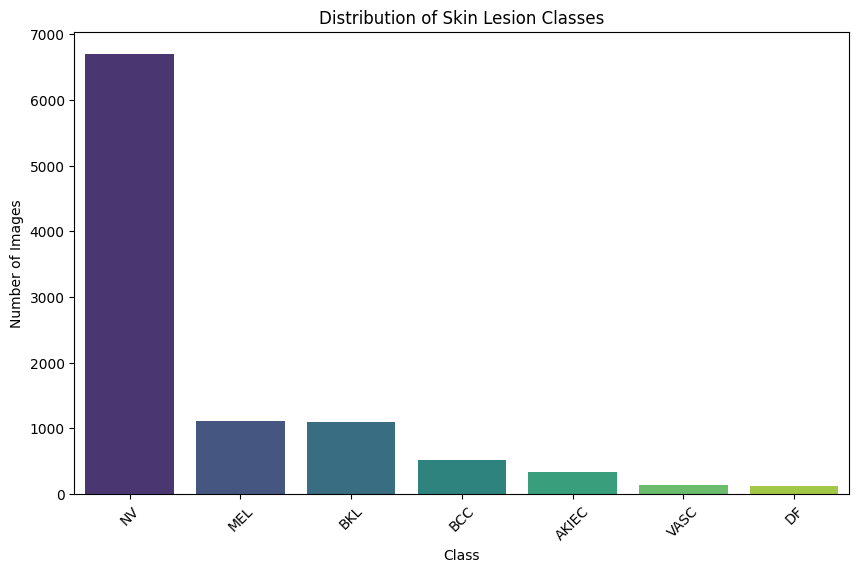

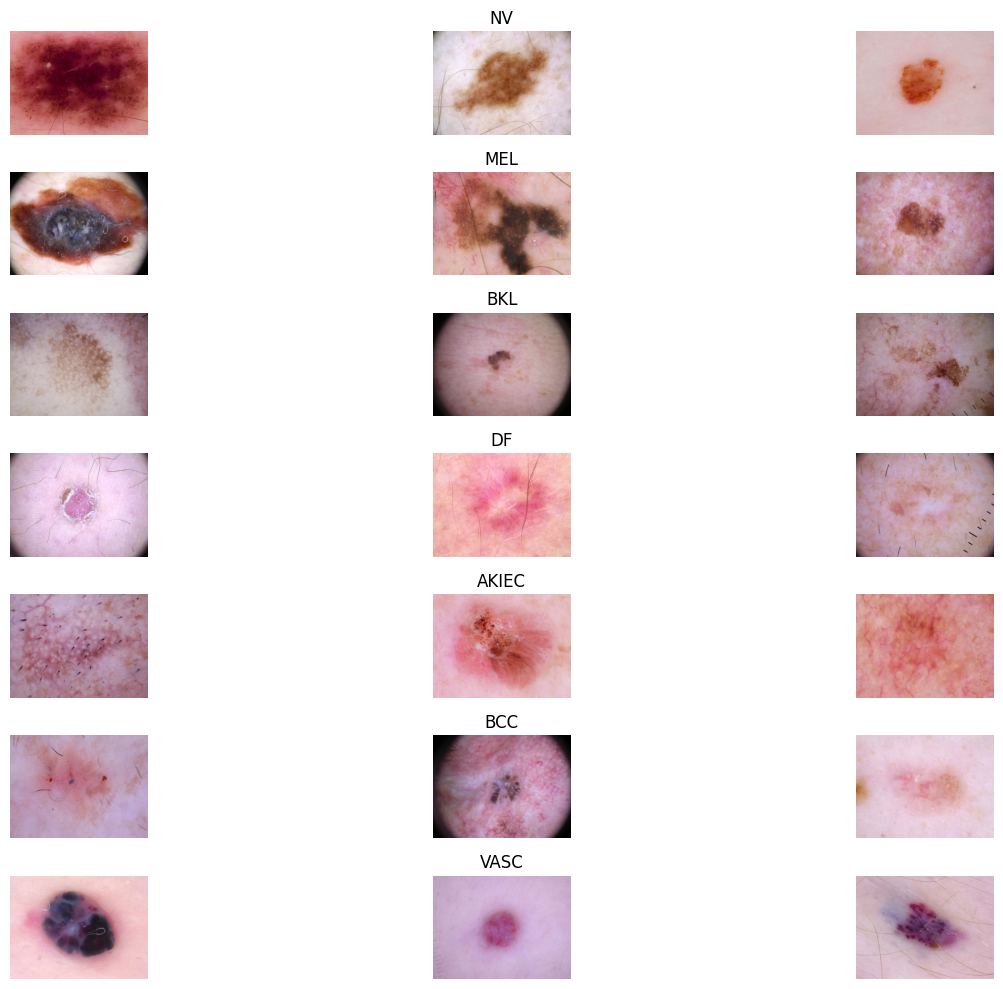

In [29]:
image_id_column = 'image'  

# Check the distribution of the classes
class_distribution = metadata['labels'].value_counts()
print(class_distribution)

# Plot the distribution of the classes
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, hue=class_distribution.index, palette='viridis', dodge=False, legend=False)
plt.title('Distribution of Skin Lesion Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Define a function to display example images from each class
def display_examples(metadata, data_dir, image_id_column, num_examples=3):
    classes = metadata['labels'].unique()
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(classes):
        class_images = metadata[metadata['labels'] == cls].sample(num_examples, random_state=42)[image_id_column].values
        for j, img_id in enumerate(class_images):
            img_path = os.path.join(data_dir, img_id + '.jpg')
            img = Image.open(img_path)
            plt.subplot(len(classes), num_examples, i*num_examples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 1:
                plt.title(cls)
    
    plt.tight_layout()
    plt.show()

# Display example images
display_examples(metadata, 'HAM10000/images', image_id_column)


The bar chart clearly shows a data imbalance, with 67% of the samples being NV.

To address this class imbalance, I will employ data augmentation and oversampling of the minority classes. The re-balanced dataset is saved as "resampled_metadata.csv" and will be used in the subsequent CNN models.

Due to processing time constraints, these models have not yet been run. However, in anticipation of the results from these pre-trained models, I have prepared an ensemble classifier. This classifier averages the predictions from each model and classifies based on the consensus, with the goal of improving overall classification accuracy. While all models are included in the code, adjustments may be made depending on their individual accuracy statistics.

This is coded below:

Training on fold 1...
Found 35201 validated image filenames belonging to 7 classes.
Found 11734 validated image filenames belonging to 7 classes.
Epoch 1/25
1101/1101 [==============================] - 688s 625ms/step - loss: 0.9759 - accuracy: 0.6366 - val_loss: 0.9159 - val_accuracy: 0.6690
Epoch 2/25
1101/1101 [==============================] - 683s 620ms/step - loss: 0.9609 - accuracy: 0.6433 - val_loss: 1.2284 - val_accuracy: 0.5846
Epoch 3/25
1101/1101 [==============================] - 689s 625ms/step - loss: 0.9515 - accuracy: 0.6454 - val_loss: 1.0368 - val_accuracy: 0.6330
Epoch 4/25
1101/1101 [==============================] - 697s 633ms/step - loss: 0.9386 - accuracy: 0.6495 - val_loss: 2.3710 - val_accuracy: 0.5086
Epoch 5/25
1101/1101 [==============================] - 682s 619ms/step - loss: 0.9194 - accuracy: 0.6562 - val_loss: 0.8776 - val_accuracy: 0.6724
Epoch 6/25
1101/1101 [==============================] - 691s 627ms/step - loss: 0.9123 - accuracy: 0.6605 - val_lo

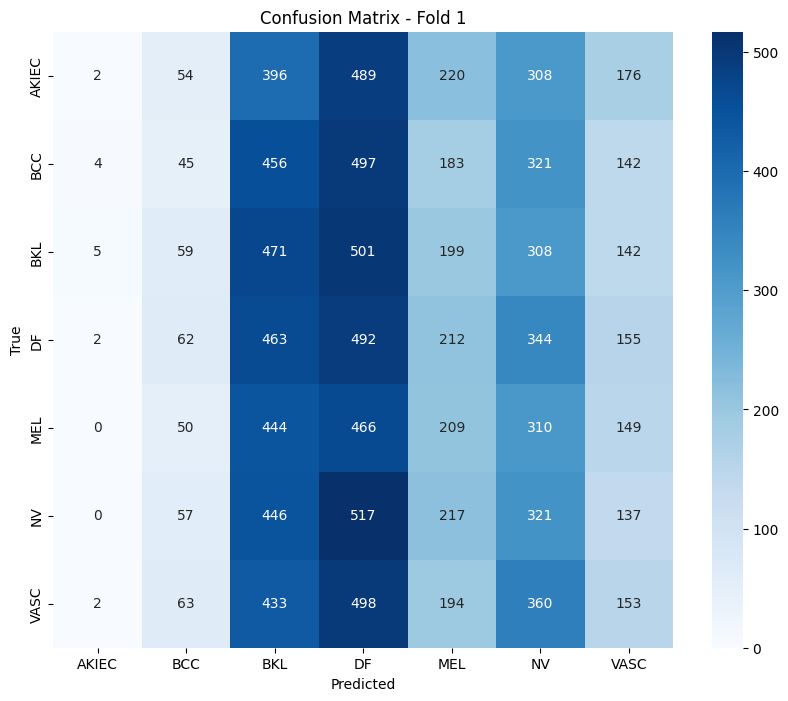

Training on fold 2...
Found 35201 validated image filenames belonging to 7 classes.
Found 11734 validated image filenames belonging to 7 classes.
Epoch 1/25
1101/1101 [==============================] - 686s 623ms/step - loss: 0.7960 - accuracy: 0.7024 - val_loss: 0.8843 - val_accuracy: 0.6797
Epoch 2/25
1101/1101 [==============================] - 685s 622ms/step - loss: 0.7756 - accuracy: 0.7096 - val_loss: 0.8375 - val_accuracy: 0.7027
Epoch 3/25
1101/1101 [==============================] - 681s 618ms/step - loss: 0.7795 - accuracy: 0.7087 - val_loss: 1.0131 - val_accuracy: 0.6834
Epoch 4/25
1101/1101 [==============================] - 679s 616ms/step - loss: 0.7750 - accuracy: 0.7115 - val_loss: 0.7228 - val_accuracy: 0.7281
Epoch 5/25
1101/1101 [==============================] - 684s 621ms/step - loss: 0.7733 - accuracy: 0.7132 - val_loss: 0.7982 - val_accuracy: 0.6992
Epoch 6/25
1101/1101 [==============================] - 679s 617ms/step - loss: 0.7555 - accuracy: 0.7151 - val_lo

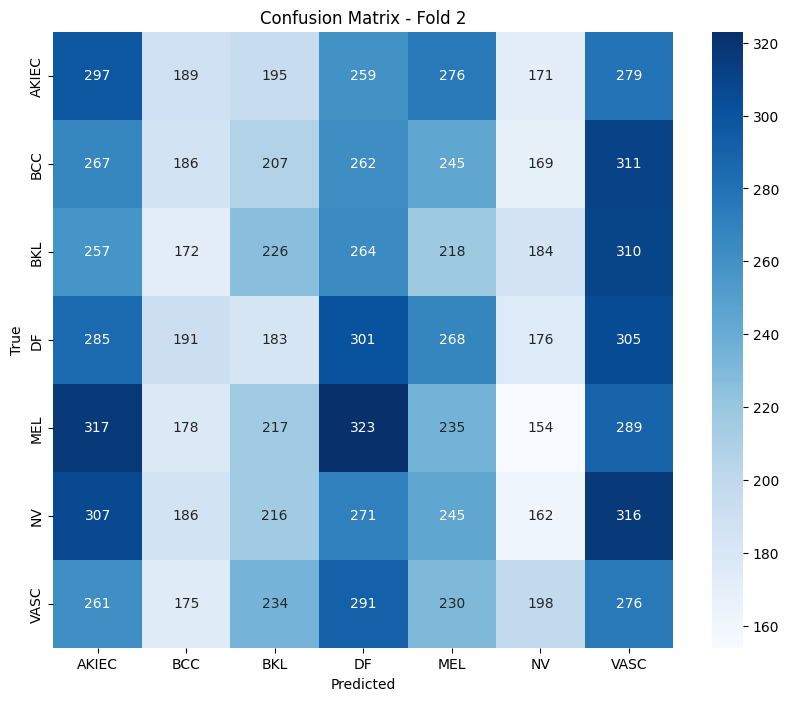

Training on fold 3...
Found 35201 validated image filenames belonging to 7 classes.
Found 11734 validated image filenames belonging to 7 classes.
Epoch 1/25
1101/1101 [==============================] - 677s 614ms/step - loss: 0.7248 - accuracy: 0.7326 - val_loss: 0.6880 - val_accuracy: 0.7419
Epoch 2/25
1101/1101 [==============================] - 670s 608ms/step - loss: 0.7192 - accuracy: 0.7315 - val_loss: 0.6246 - val_accuracy: 0.7695
Epoch 3/25
1101/1101 [==============================] - 668s 607ms/step - loss: 0.7151 - accuracy: 0.7358 - val_loss: 0.9764 - val_accuracy: 0.6895
Epoch 4/25
1101/1101 [==============================] - 669s 607ms/step - loss: 0.7134 - accuracy: 0.7344 - val_loss: 0.6377 - val_accuracy: 0.7764
Epoch 5/25
1101/1101 [==============================] - 667s 606ms/step - loss: 0.7148 - accuracy: 0.7357 - val_loss: 0.6278 - val_accuracy: 0.7777
Epoch 6/25
1101/1101 [==============================] - 666s 605ms/step - loss: 0.7116 - accuracy: 0.7383 - val_lo

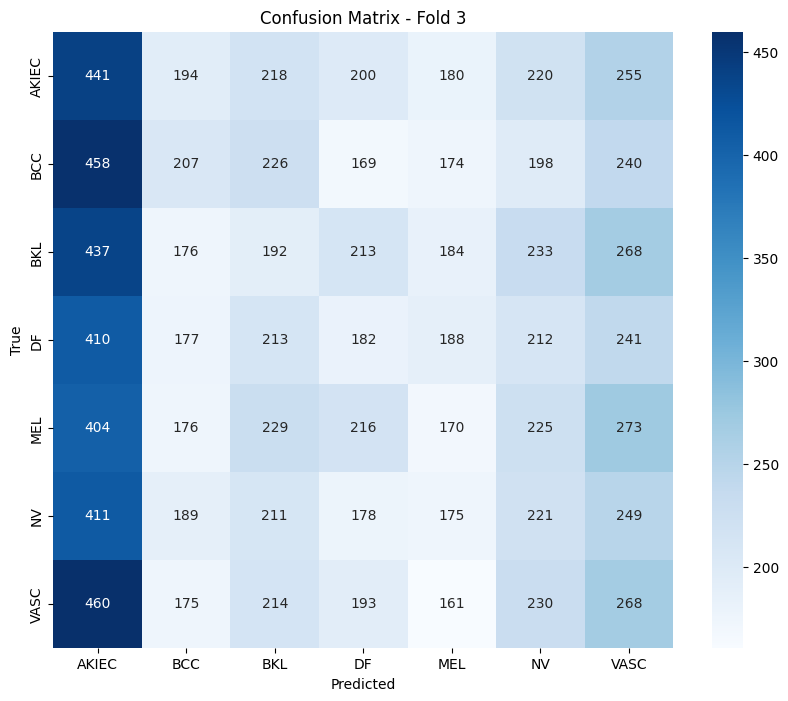

Training on fold 4...
Found 35202 validated image filenames belonging to 7 classes.
Found 11733 validated image filenames belonging to 7 classes.
Epoch 1/25
1101/1101 [==============================] - 733s 665ms/step - loss: 0.6922 - accuracy: 0.7458 - val_loss: 0.6733 - val_accuracy: 0.7906
Epoch 2/25
1101/1101 [==============================] - 737s 669ms/step - loss: 0.6954 - accuracy: 0.7449 - val_loss: 0.8666 - val_accuracy: 0.7130
Epoch 3/25
1101/1101 [==============================] - 737s 670ms/step - loss: 0.6819 - accuracy: 0.7509 - val_loss: 0.6616 - val_accuracy: 0.7537
Epoch 4/25
1101/1101 [==============================] - 732s 665ms/step - loss: 0.6753 - accuracy: 0.7515 - val_loss: 0.5975 - val_accuracy: 0.7949
Epoch 5/25
1101/1101 [==============================] - 674s 611ms/step - loss: 0.6657 - accuracy: 0.7567 - val_loss: 0.6377 - val_accuracy: 0.7833
Epoch 6/25
1101/1101 [==============================] - 670s 608ms/step - loss: 0.6795 - accuracy: 0.7499 - val_lo

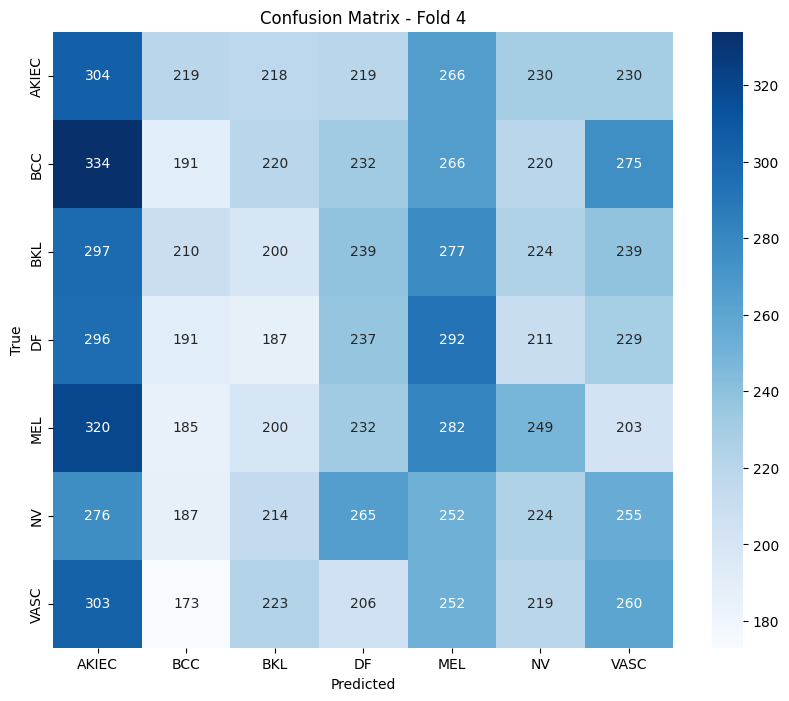

In [32]:
# Necessary imports
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# Define the path to the dataset
data_dir = 'HAM10000/images'

# Load the original metadata
metadata_path = os.path.join('HAM10000', 'GroundTruth.csv')
metadata = pd.read_csv(metadata_path)

# Class columns representing different types of skin cancer
class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Create a function to map binary columns to a single label
def map_labels(row):
    for col in class_columns:
        if row[col] == 1.0:
            return col
    return 'unknown'

# Apply the function to create the 'labels' column
metadata['labels'] = metadata.apply(map_labels, axis=1)

# Ensure the image filenames are correctly formatted
metadata['image'] = metadata['image'].apply(lambda x: x + '.jpg')

# Extract the features and labels
X = metadata['image']
y = metadata['labels']

# Resample the dataset using RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with the resampled data
resampled_metadata = pd.DataFrame({
    'image': X_resampled.flatten(),
    'labels': y_resampled
})

# Define image size and batch size
image_size = (128, 128)  # Adjust based on the model requirements
batch_size = 32

# Initialize ImageDataGenerator with stronger data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=60,  # Increased rotation range
    width_shift_range=0.3,  # Increased width shift
    height_shift_range=0.3,  # Increased height shift
    shear_range=0.3,  # Increased shear range
    zoom_range=0.3,  # Increased zoom range
    brightness_range=[0.8, 1.2],  # Added brightness adjustment
    fill_mode='nearest'
)

# K-Fold Cross Validation, random state is included for reproducibility
kf = KFold(n_splits=4, shuffle=True, random_state=42)  

fold_no = 1
for train_index, val_index in kf.split(resampled_metadata):
    print(f'Training on fold {fold_no}...')
    train_data = resampled_metadata.iloc[train_index]
    val_data = resampled_metadata.iloc[val_index]

    # Create training data generator
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=data_dir,
        x_col='image',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Create validation data generator
    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=data_dir,
        x_col='image',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Build and compile the model
    model_my_nn_new = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_columns), activation='softmax')
    ])

    model_my_nn_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model_my_nn.fit(
        train_generator,
        epochs=25,
        validation_data=validation_generator
    )

    # Evaluate the model on the validation set
    loss, accuracy = model_my_nn.evaluate(validation_generator)
    print(f'Validation accuracy for fold {fold_no}: {accuracy * 100:.4f}%')

    # Get predictions on the validation set
    validation_generator.reset()
    predictions = model_my_nn.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
    predicted_class_indices = np.argmax(predictions, axis=1)

    # Get the true labels
    true_labels = validation_generator.classes
    labels = list(validation_generator.class_indices.keys())

    # Print a classification report
    print('Classification Report')
    print(classification_report(true_labels, predicted_class_indices, target_names=labels))

    # Plot a confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Fold {fold_no}')
    plt.show()

    # Save the model for this fold
    model_my_nn_new.save(f'model_my_nn_fold_{fold_no}.keras')

    fold_no += 1

# Save resampled metadata for later use
resampled_metadata.to_csv('resampled_metadata.csv', index=False)


The model named model_my_nn_fold_4 demonstrated the best performance and has been selected for implementation.

The following code blocks illustrate the exploration of model efficacy.

While these models and their corresponding results offer valuable insights into the project workflow, they were ultimately not used in the final model due to their inferior performance.

## Examining Accuracies of the Models

Now, we will examine the accuracies of each model.

In [39]:
accuracies_df = pd.read_csv('model_accuracies.csv')
accuracies_df.head(13)

,Model_parameters,Model_description,Training_Accuracy,Validaion_Accuracy
0,model_my_nn.keras,"initial, simple 13 layer CNN models",0.6803,0.7294
1,model_my_nn_2.keras,"initial, simple 16 layer CNN models",0.9507,0.3070
2,model_Resnet.keras,modified ResNet50,0.7610,0.0120
3,model_Eff.keras,modified EfficientNetB0,0.8901,0.0811
4,model_Resnet.keras,modified InceptionV3,0.9995,0.4261
5,model_VGG16.keras,modified VGG16,0.9907,0.3953
6,model_DenseNet.keras,modified DenseNet,0.9971,0.4713
7,model_NASNet.keras,modified NASNetMobile,0.9543,0.3958
8,model_Xcept.keras,modified Xception,0.9643,0.4242
9,model_my_nn_fold_1.keras,"13 layer model, k fold 1",0.7048,0.4334


The modified pre-trained models exhibited high training accuracies but performed poorly on validation data, strongly indicating overfitting. This is likely due to these models being originally designed to identify a large number of classes (1000 or more), which may not generalize well to our specific task.

In contrast, the smaller models I developed, which have significantly fewer layers, demonstrated better generalization. Notably, in the case of model_my_nn_fold_14, the validation accuracy exceeded the training accuracy, suggesting it is well-tuned to the task.

Below is a visualization comparing the validation accuracy to training accuracy ratios for each CNN.


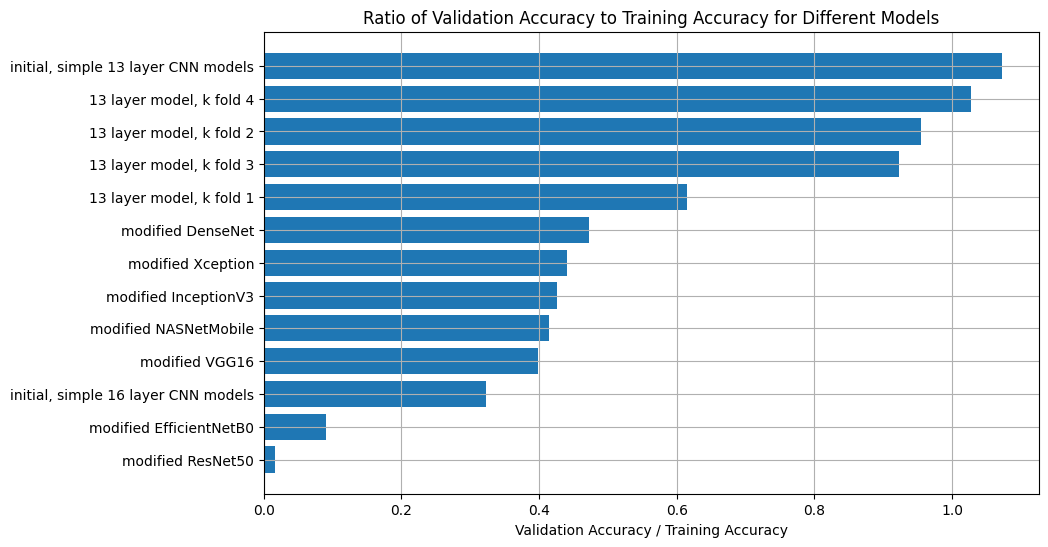

In [43]:
# Calculate the ratio of Validation Accuracy to Training Accuracy
accuracies_df['Accuracy_Ratio'] = accuracies_df['Validaion_Accuracy'] / accuracies_df['Training_Accuracy']

# Sort the DataFrame by Accuracy_Ratio in descending order
accuracies_df = accuracies_df.sort_values(by='Accuracy_Ratio', ascending=True)

# Create a bar plot to visualize the ratios
plt.figure(figsize=(10, 6))
plt.barh(accuracies_df['Model_description'], accuracies_df['Accuracy_Ratio'])
plt.xlabel('Validation Accuracy / Training Accuracy')
plt.title('Ratio of Validation Accuracy to Training Accuracy for Different Models')
plt.grid(True)

plt.show()

I can now proceed with implementing the best-performing model, model_my_nn_fold_4.

First, I will use the stored parameters to create functions for processing test images (ensuring they have the correct dimensions and formatting for the model) and making predictions based on the parameters of the implemented model.

In [69]:
from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import Adam

model = load_model('model_my_nn_fold_4.keras', compile=False)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


def predict(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Make a prediction
    predictions = model.predict(img)
    return predictions

def preprocess_image(image_path):
    from tensorflow.keras.preprocessing import image
    import numpy as np
    img = image.load_img(image_path, target_size=(128, 128))  # assuming 224x224 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # adding batch dimension
    img_array /= 255.0  # normalize to [0, 1]
    return img_array


In [84]:
# Path to your test image

image_path = r'C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\test_images\test_DF.jpg'


# Preprocess the image
img = preprocess_image(image_path)

# Make a prediction
predictions = model.predict(img)

# Decode the predictions (adjust according to your model's output)
# For example, if your model output is softmax with 7 classes:
class_labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
predicted_class = np.argmax(predictions, axis=-1)

print(f"Predicted class: {class_labels[predicted_class[0]]}")

1/1 [==============================] - 0s 52ms/step
Predicted class: BKL


## Note: The code cells and outputs below were used as exploratory models and were not used in the final deployment.  They are included to show analyses and are not implemented in the deployed model.

### Building the initial neural net model: model_my_nn

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
import scipy


# Build the model
model_my_nn = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(len(class_columns), activation='softmax')
])

# Compile the model, optimizer, loss, and metrics uses the most common for classification
model_my_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_my_nn.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                      

This model is over classifying NV.

To improve accuracy, I will try a more complex (Increased layered) neural network labeled model_my_nn_2


## Trying another model:
Key Differences Between model_my_nn and model_my_nn_2
Kernel Initializer:

model_my_nn uses the HeNormal initializer for all convolutional and dense layers.
model_my_nn_2 uses the default initializer (typically GlorotUniform) for its convolutional and dense layers.
Number of Layers:

model_my_nn has three convolutional layers, each followed by a max-pooling layer.
model_my_nn_2 has four convolutional layers, each followed by a max-pooling layer.
Number of Filters:

model_my_nn has convolutional layers with 32, 64, and 128 filters.
model_my_nn_2 has convolutional layers with 32, 64, 128, and 256 filters.
Dense Layers:

model_my_nn includes a dense layer with 128 units.
model_my_nn_2 includes a dense layer with 512 units.

In [15]:
import os
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Define the path to the dataset
data_dir = 'HAM10000/images'

# Load the original metadata
metadata_path = os.path.join('HAM10000', 'GroundTruth.csv')
metadata = pd.read_csv(metadata_path)

# Class columns representing different types of skin cancer
class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Create a function to map binary columns to a single label
def map_labels(row):
    for col in class_columns:
        if row[col] == 1.0:
            return col
    return 'unknown'

# Apply the function to create the 'labels' column
metadata['labels'] = metadata.apply(map_labels, axis=1)

# Ensure the image filenames are correctly formatted
metadata['image'] = metadata['image'].apply(lambda x: x + '.jpg')

# Extract the features and labels
X = metadata['image']
y = metadata['labels']

# Resample the dataset
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Create a new data frame with the resampled data
resampled_metadata = pd.DataFrame({
    'image': X_resampled.flatten(),
    'labels': y_resampled
})

# Define image size and batch size
image_size = (128, 128)  # Adjust based on the model requirements
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create a training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Build another more complex model, model_my_nn_2
model_my_nn_2 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_columns), activation='softmax')
])

# Compile the model with a lower learning rate
model_my_nn_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Display the model summary
model_my_nn_2.summary()

# Train the model
history = model_my_nn_2.fit(
    train_generator,
    epochs=50,  
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_my_nn_2.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Save the model after training
model_my_nn_2.save('model_my_nn_2.keras')


Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,113,031 (19.50 MB)

 Trainable params: 5,112,071 (19.50 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50


C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 593s 500ms/step - accuracy: 0.4835 - loss: 1.5751 - val_accuracy: 0.1712 - val_loss: 4.1132
Epoch 2/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 595s 505ms/step - accuracy: 0.6332 - loss: 0.9588 - val_accuracy: 0.1951 - val_loss: 4.0773
Epoch 3/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 592s 503ms/step - accuracy: 0.6901 - loss: 0.8294 - val_accuracy: 0.2030 - val_loss: 4.7806
Epoch 4/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 599s 508ms/step - accuracy: 0.7255 - loss: 0.7425 - val_accuracy: 0.2399 - val_loss: 4.4699
Epoch 5/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 592s 502ms/step - accuracy: 0.7515 - loss: 0.6681 - val_accuracy: 0.2334 - val_loss: 5.0915
Epoch 6/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 594s 505ms/step - accuracy: 0.7670 - loss: 0.6238 - val_accuracy: 0.2510 - val_loss: 4.9544
Epoch 7/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 600s 510ms/step - accuracy: 0.7841 - loss: 0.5814 - val_accuracy: 0.2388 - val_loss: 5.1270
Epoch 8/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 600s 509ms/step - accuracy: 0.8

294/294 ━━━━━━━━━━━━━━━━━━━━ 90s 306ms/step
Classification Report
              precision    recall  f1-score   support

       AKIEC       0.06      0.04      0.05       323
         BCC       0.06      0.07      0.06       493
         BKL       0.11      0.43      0.18      1027
          DF       0.01      0.05      0.01       105
         MEL       0.10      0.34      0.16       972
          NV       0.68      0.03      0.05      6333
        VASC       0.01      0.04      0.02       134

    accuracy                           0.11      9387
   macro avg       0.15      0.14      0.07      9387
weighted avg       0.49      0.11      0.07      9387



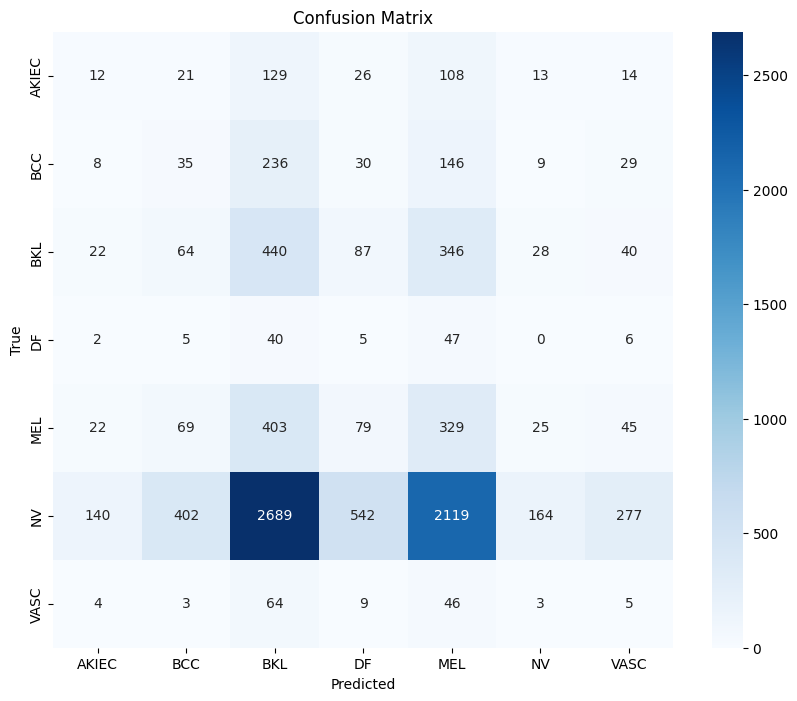

In [17]:
# Get predictions on the validation set
validation_generator.reset()
predictions = model_my_nn_2.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Results of new neural network model (model_my_nn_2)

The new model has shown improvement in most metrics for non-NV classification and is a clear improvement from the initial network.

To find the best possible classification, I will follow by adapting several well known, pre-trained models:

1. ResNet50
2. EfficientNetB0
3. InceptionV3
4. VGG16
5. DenseNet
6. NASNetMobile
7. Xception


### Try Resnet

Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.
Epoch 1/50


C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1016s 859ms/step - accuracy: 0.1665 - loss: 1.9017 - val_accuracy: 0.0143 - val_loss: 3.1266
Epoch 2/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1006s 856ms/step - accuracy: 0.1813 - loss: 1.8365 - val_accuracy: 0.0129 - val_loss: 3.4594
Epoch 3/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1004s 854ms/step - accuracy: 0.1799 - loss: 1.8316 - val_accuracy: 0.0124 - val_loss: 3.3609
Epoch 4/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1007s 856ms/step - accuracy: 0.1815 - loss: 1.8325 - val_accuracy: 0.0157 - val_loss: 3.3643
Epoch 5/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1003s 853ms/step - accuracy: 0.1859 - loss: 1.8251 - val_accuracy: 0.0181 - val_loss: 3.5061
Epoch 6/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1003s 853ms/step - accuracy: 0.1938 - loss: 1.8171 - val_accuracy: 0.0200 - val_loss: 3.4706
Epoch 7/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1008s 857ms/step - accuracy: 0.1992 - loss: 1.8128 - val_accuracy: 0.0294 - val_loss: 3.6093
Epoch 8/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1004s 854ms/step - accur

C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

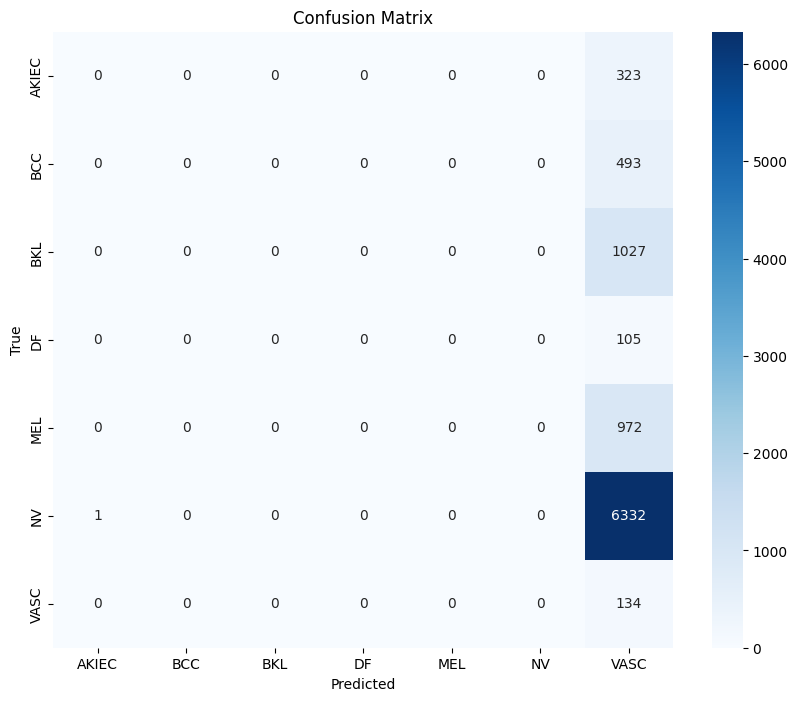

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix


# Define the path to the dataset
data_dir = 'HAM10000/images'

# Load resampled metadata
resampled_metadata_path = 'resampled_metadata.csv'
resampled_metadata = pd.read_csv(resampled_metadata_path)

# Define image size and batch size
image_size = (224, 224)  
batch_size = 32

# Initialize ImageDataGenerator without data augmentation for validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the pre-trained ResNet50 model without the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(resampled_metadata['labels'].unique()), activation='softmax')(x)

# Build the complete model
model_Resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_Resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
history = model_Resnet.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
model_Resnet.load_weights('best_model.keras')

# Evaluate the model
loss, accuracy = model_Resnet.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_Resnet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model after training
model_Resnet.save('model_Resnet.keras')


294/294 ━━━━━━━━━━━━━━━━━━━━ 201s 682ms/step
Classification Report
              precision    recall  f1-score   support

       AKIEC       0.00      0.00      0.00       323
         BCC       0.00      0.00      0.00       493
         BKL       0.00      0.00      0.00      1027
          DF       0.00      0.00      0.00       105
         MEL       0.00      0.00      0.00       972
          NV       0.00      0.00      0.00      6333
        VASC       0.01      1.00      0.03       134

    accuracy                           0.01      9387
   macro avg       0.00      0.14      0.00      9387
weighted avg       0.00      0.01      0.00      9387



C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

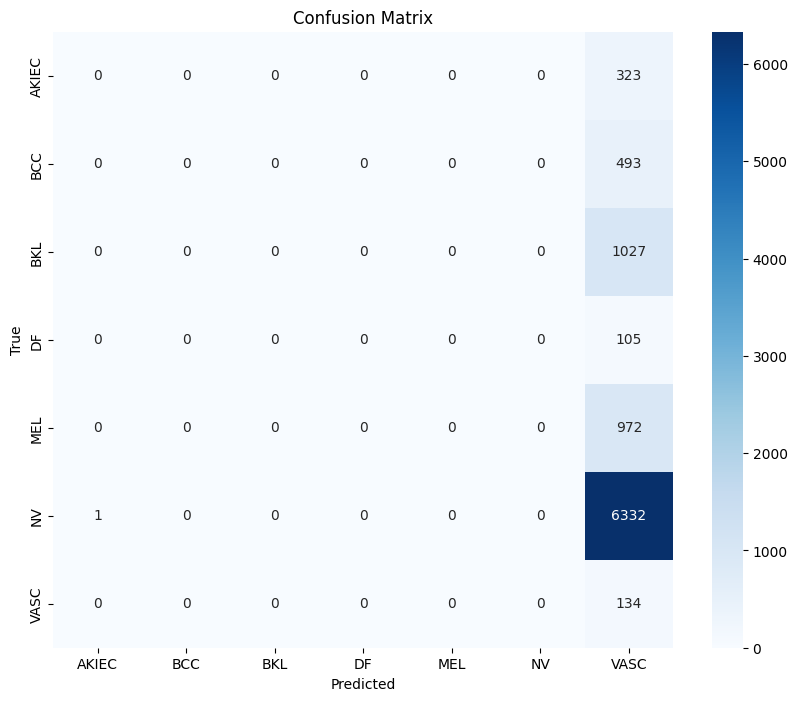

In [19]:
# Get predictions on the validation set
validation_generator.reset()
predictions = model_Resnet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Try EfficientNetB0 

In [20]:
from tensorflow.keras.applications import EfficientNetB0


# Define image size and batch size for EfficientNetB0, 224x224
image_size = (224, 224)  
batch_size = 32

# Initialize ImageDataGenerator with data augmentation for adjusted image size
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator_Eff = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator_Eff = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the EfficientNetB0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_Eff = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_Eff.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Display the model summary
model_Eff.summary()

# Train the model
history = model_Eff.fit(
    train_generator_Eff,
    epochs=50,
    validation_data=validation_generator_Eff
)

# Evaluate the model
loss, accuracy = model_Eff.evaluate(validation_generator_Eff)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Save the model_Eff
model_Eff.save('model_Eff.keras')

Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,368,490 (20.48 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50


C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 982s 824ms/step - accuracy: 0.1720 - loss: 1.8470 - val_accuracy: 0.0525 - val_loss: 3.5430
Epoch 2/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 969s 823ms/step - accuracy: 0.1764 - loss: 1.8327 - val_accuracy: 0.0344 - val_loss: 3.6106
Epoch 3/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 967s 821ms/step - accuracy: 0.1702 - loss: 1.8341 - val_accuracy: 0.0143 - val_loss: 3.7022
Epoch 4/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 972s 825ms/step - accuracy: 0.1698 - loss: 1.8318 - val_accuracy: 0.0143 - val_loss: 3.5727
Epoch 5/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 962s 817ms/step - accuracy: 0.1712 - loss: 1.8322 - val_accuracy: 0.0143 - val_loss: 3.6374
Epoch 6/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 965s 819ms/step - accuracy: 0.1743 - loss: 1.8302 - val_accuracy: 0.0143 - val_loss: 3.6360
Epoch 7/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 971s 825ms/step - accuracy: 0.1734 - loss: 1.8321 - val_accuracy: 0.0112 - val_loss: 3.7614
Epoch 8/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 974s 827ms/step - accuracy: 0.1

### Try InceptionV3 Pre-trained Model

Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 149, 149, 32)      │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 149, 149, 32)      │              96 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization_10[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 147, 147, 32)      │              96 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_11[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 147, 147, 64)      │             192 │ conv2d_12[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_10              │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d_10[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 73, 73, 80)        │             240 │ conv2d_13[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 71, 71, 192)       │         138,24

 Total params: 23,908,135 (91.20 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/50


C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.4976 - loss: 1.3353 - val_accuracy: 0.1785 - val_loss: 3.4164
Epoch 2/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1719s 1s/step - accuracy: 0.6601 - loss: 0.9255 - val_accuracy: 0.1918 - val_loss: 3.1787
Epoch 3/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1723s 1s/step - accuracy: 0.6935 - loss: 0.8281 - val_accuracy: 0.2025 - val_loss: 2.9283
Epoch 4/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1723s 1s/step - accuracy: 0.7233 - loss: 0.7503 - val_accuracy: 0.2155 - val_loss: 2.9200
Epoch 5/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1725s 1s/step - accuracy: 0.7512 - loss: 0.6898 - val_accuracy: 0.2186 - val_loss: 3.2228
Epoch 6/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1726s 1s/step - accuracy: 0.7657 - loss: 0.6389 - val_accuracy: 0.2348 - val_loss: 2.7485
Epoch 7/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1718s 1s/step - accuracy: 0.7763 - loss: 0.6192 - val_accuracy: 0.2230 - val_loss: 3.1285
Epoch 8/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1724s 1s/step - accuracy: 0.7845 - loss: 0.58

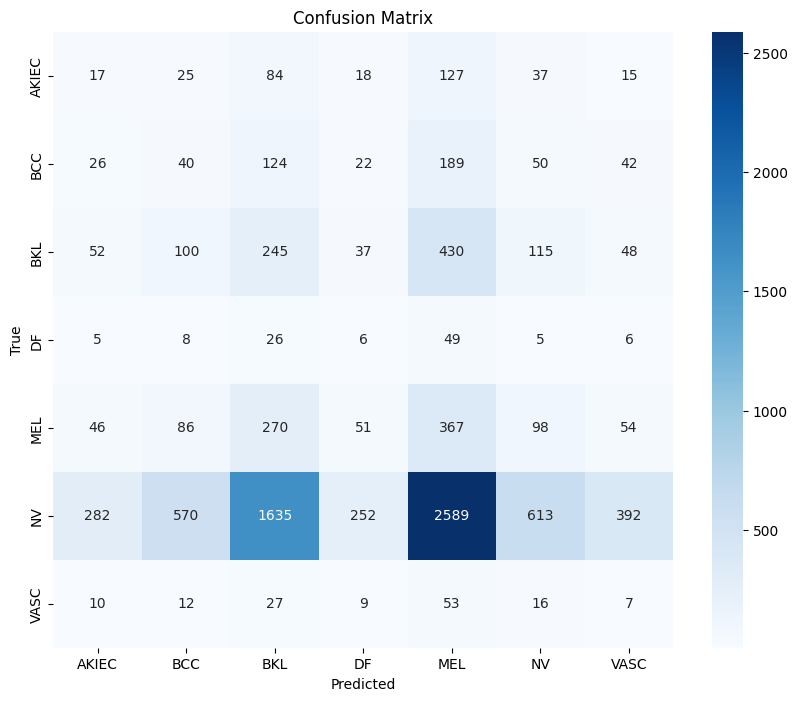

In [21]:

from tensorflow.keras.applications import InceptionV3

# Define image size and batch size, InceptionV3 employs 299x299 images
image_size = (299, 299)
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_IncV3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_IncV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Display the model summary
model_IncV3.summary()

# Train the model
history = model_IncV3.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_IncV3.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_IncV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_IncV3.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_IncV3.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_IncV3.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Save the model_VGG16
model_IncV3.save('model_IncV3.keras')

### Try VGG16

Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,247,175 (58.16 MB)

 Trainable params: 532,487 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/25


C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2129s 2s/step - accuracy: 0.2777 - loss: 1.7562 - val_accuracy: 0.0863 - val_loss: 3.5571
Epoch 2/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2130s 2s/step - accuracy: 0.4483 - loss: 1.4578 - val_accuracy: 0.1204 - val_loss: 3.3853
Epoch 3/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2138s 2s/step - accuracy: 0.4847 - loss: 1.3711 - val_accuracy: 0.1208 - val_loss: 3.3579
Epoch 4/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2134s 2s/step - accuracy: 0.5073 - loss: 1.3102 - val_accuracy: 0.1315 - val_loss: 3.4152
Epoch 5/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2124s 2s/step - accuracy: 0.5268 - loss: 1.2523 - val_accuracy: 0.1243 - val_loss: 3.3407
Epoch 6/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2133s 2s/step - accuracy: 0.5336 - loss: 1.2248 - val_accuracy: 0.1415 - val_loss: 3.3602
Epoch 7/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2126s 2s/step - accuracy: 0.5522 - loss: 1.1850 - val_accuracy: 0.1363 - val_loss: 3.3861
Epoch 8/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2133s 2s/step - accuracy: 0.5619 - loss: 1.16

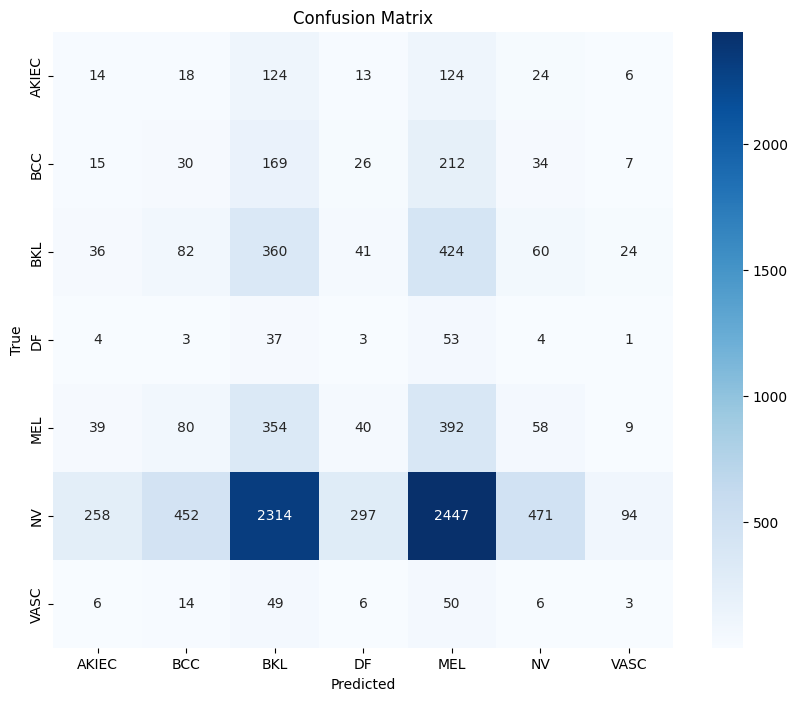

In [22]:

from tensorflow.keras.applications import VGG16


# Define image size and batch size, VGG16 uses 224x224 images
image_size = (224, 224)
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_VGG16 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Display the model summary
model_VGG16.summary()

# Train the model
history = model_VGG16.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_VGG16.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_VGG16.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_VGG16.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_VGG16.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


model_VGG16.save('model_VGG16.keras')

### Try DenseNet

Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer_7[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 8,094,279 (30.88 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/25


C:\Users\nickk\Brainstation Files\Capstone_Skin\Capstone_Skin_Cancer\skin_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1396s 1s/step - accuracy: 0.4731 - loss: 1.3687 - val_accuracy: 0.1732 - val_loss: 3.2126
Epoch 2/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1402s 1s/step - accuracy: 0.6466 - loss: 0.9551 - val_accuracy: 0.1988 - val_loss: 2.7931
Epoch 3/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1403s 1s/step - accuracy: 0.6890 - loss: 0.8347 - val_accuracy: 0.2104 - val_loss: 3.0774
Epoch 4/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1405s 1s/step - accuracy: 0.7157 - loss: 0.7649 - val_accuracy: 0.2187 - val_loss: 2.6537
Epoch 5/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1401s 1s/step - accuracy: 0.7330 - loss: 0.7160 - val_accuracy: 0.2250 - val_loss: 2.8082
Epoch 6/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1414s 1s/step - accuracy: 0.7578 - loss: 0.6659 - val_accuracy: 0.2321 - val_loss: 2.9266
Epoch 7/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1415s 1s/step - accuracy: 0.7628 - loss: 0.6475 - val_accuracy: 0.2322 - val_loss: 2.9779
Epoch 8/25
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1417s 1s/step - accuracy: 0.7725 - loss: 0.61

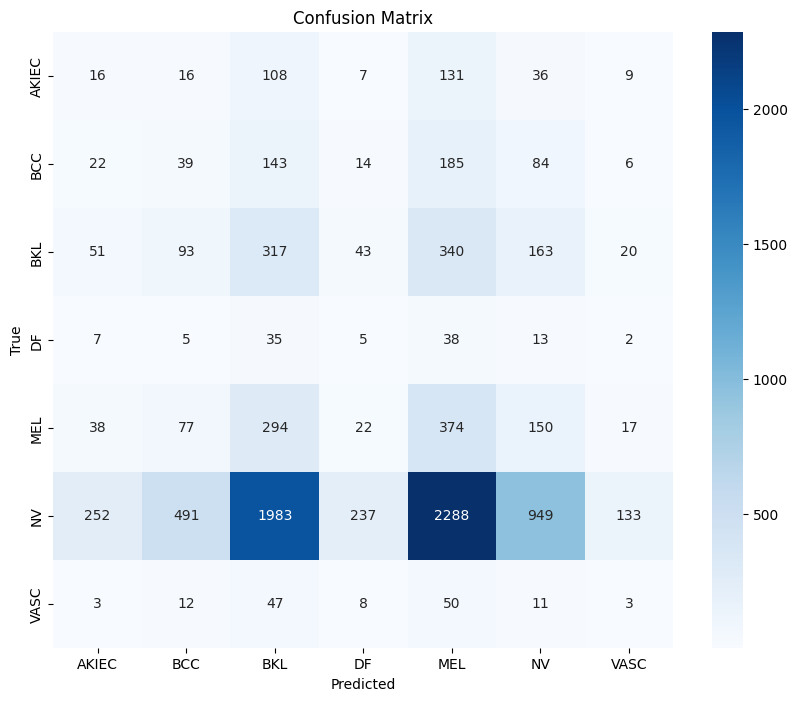

In [23]:

from tensorflow.keras.applications import DenseNet121


# Define image size and batch size, DenseNet121 expects 224x224 images
image_size = (224, 224)  
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_DenseNet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_DenseNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Display the model summary
model_DenseNet.summary()

# Train the model
history = model_DenseNet.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_DenseNet.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_DenseNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_DenseNet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_DenseNet.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_DenseNet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


model_DenseNet.save('model_DenseNet.keras')

### Try NASNet 

Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                      

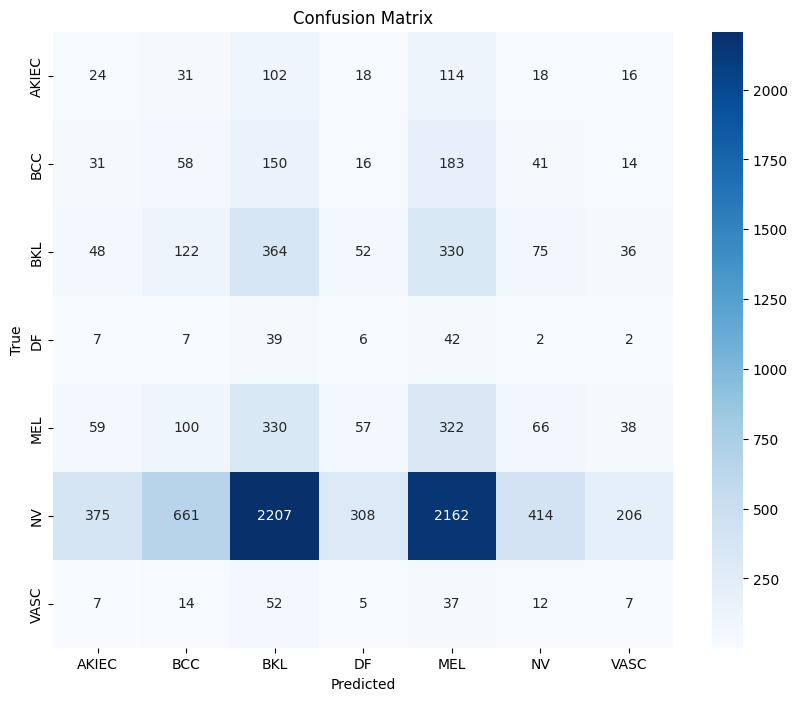

In [14]:

from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


# Define image size and batch size
image_size = (224, 224)  # NASNetMobile expects 224x224 images
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the NASNetMobile model pre-trained on ImageNet
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_NASNet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_NASNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

# Display the model summary
model_NASNet.summary()

# Train the model
history = model_NASNet.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_NASNet.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_NASNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_NASNet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_NASNet.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_NASNet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


model_NASNet.save('model_NASNet.keras')

### Try Xception 

In [34]:

from tensorflow.keras.applications import Xception


# Define image size and batch size, Xception uses 299x299 images
image_size = (299, 299) 
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the Xception model pre-trained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_Xcept = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_Xcept.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Display the model summary
model_Xcept.summary()

# Train the model
history = model_Xcept.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_Xcept.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_Xcept.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_Xcept.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_Xcept.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_Xcept.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


model_Xcept.save('model_Xcept.keras')

## Make a dataframe of the classification accuracy for each model

Here I am creating a dataframe to visualize the individual accuracies of each modl


### Creating an ensemble of neural networks

This approach involves:

1. Creating multiple variations of created neural network architecture. 
2. Training each variation independently.
3. Using the average of the predictions from all trained models for the final classification. 

This ensemble method will try to improve the accuracy and robustness of your classification model.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(variation):
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))
    
    if variation == 1:
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
    elif variation == 2:
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
    elif variation == 3:
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
    
    model.add(Dense(len(class_columns), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [35]:
# Train each model
models = []
variations = [1, 2, 3]
for variation in variations:
    print(f"Training model variation {variation}")
    model = create_model(variation)
    model.fit(train_generator, epochs=25, validation_data=validation_generator)
    models.append(model)
    model.save(f'model_variation_{variation}.keras')


### Average the Predictions

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Load models
models = [load_model(f'model_variation_{i}.keras') for i in variations]

# Get predictions from each model
predictions = [model.predict(validation_generator) for model in models]

# Average the predictions
avg_predictions = np.mean(predictions, axis=0)

# Get the final predicted class indices
predicted_class_indices = np.argmax(avg_predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Load the Trained Models and Generate Predictions By Average

Next, I will try an ensemble of all created networks to try and provide the most accurate predictive mode


In [36]:

# Load the saved models
model_my_nn = load_model('model_my_nn.keras')
model_my_nn_2 = load_model('model_my_nn_2.keras')
model_Resnet = load_model('model_Resnet.keras')
model_Eff = load_model('model_Eff.keras')
model_IncV3 = load_model('model_IncV3.keras')
model_VGG16 = load_model('model_VGG16.hkeras')
model_DenseNet = load_model('model_DenseNet.keras')
model_NASNet = load_model('model_NASNet.keras')
model_Xcept = load_model('model_Xcept.keras')

# Generate predictions
predictions_my_nn = model_my_nn.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_my_nn_2 = model_my_nn_2.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_Resnet = model_Resnet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_Eff = model_Eff.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_IncV3 = model_IncV3.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_VGG16 = model_VGG16.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_DenseNet = model_DenseNet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_NASNet = model_NASNet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_Xcept = model_Xcept.predict(validation_generator, steps=validation_generator.n // batch_size + 1)

# Average the predictions
average_predictions = (predictions_my_nn + predictions_my_nn_2 + predictions_Resnet + predictions_Eff +
                       predictions_IncV3 + predictions_VGG16 + predictions_DenseNet + predictions_NASNet +
                       predictions_Xcept) / 9

# Assign the category based on the highest average probability
predicted_class_indices = np.argmax(average_predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
